> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

TODO

add description

In [1]:
import pandas as pd
from datetime import datetime

Time series multivariate forecasting can be achieved using machine learning models, such as: linear regression for regression problems or SVM, decision tree for classification problems.

For this example, we are going to use ```Beijing PM2.5 Dataset```. The dataset contains hourly data of the PM2.5 colleted from US Embassy in Beijing. PM2.5 is a common measurement used to measures air quality. The dataset also include variable like dew point, temperature, pressure, wind direction, wind speed, and etc.

The objective of this tutorial is to forecast the PM2.5 value for the next day, which is the next 24 hours. By using machine learning models, we can treats dew point, temperature, pressure, and etc as our predictors and our target is the pm2.5 of the next day.

General benefits of machine learning algorithms for time series forecasting are:
- Ability to support multiple input features
- Ability to support noisy features and noise in the relationships between variables.
- Ability to handle irrelevant features.

Limitation of machine learning models is it can only make single-step prediction. For example if we have a model to predict the pm2.5 for the next hour, given the predictors for the current hour, it will predict the next hour, but it cant predict pm2.5 for the next two hour, unless the predictors for the next hour is given. This limit us to only predict single step ahead.

To solve this problem, we can build multiple models. let say we want predict next 24 hours, we would have 24 models, each model is build to predict each time step. 
	
more about the dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

In [2]:
air = pd.read_csv('../../datasets/multivariate/PRSA_data_2010.1.1-2014.12.31.csv')
air.index = pd.to_datetime(air[['year', 'month', 'day', 'hour']])
air.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


table above shows the summary of beijing air pollution dataset. ```pm2.5``` is the value of interest $y$, and ```dewp, temp, pres, cbwd, lwd, ls, lr``` are the predictors $x$.

## Descriptive Analysis

Before we start, lets quickly check the distribution, missing values, and unique values of our dataset

In [3]:
#remove unused column
air = air.drop("No", axis=1)

In [4]:
air.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
def get_missing_value_and_unique_count(dataframe):
    missing_value_count = dataframe.isna().sum()
    unique_count = dataframe.apply(lambda x: len(x.unique()))
    
    return pd.DataFrame({'missing_value': missing_value_count,'unique': unique_count})

In [6]:
# check missing values and unique count
get_missing_value_and_unique_count(air)

,missing_value,unique
year,0,5
month,0,12
day,0,31
hour,0,24
pm2.5,2067,582
DEWP,0,69
TEMP,0,64
PRES,0,60
cbwd,0,4
Iws,0,2788


In [7]:
air.apply(set)

year                        {2010, 2011, 2012, 2013, 2014}
month              {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
day      {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
hour     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pm2.5    {nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
DEWP     {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
TEMP     {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
PRES     {1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029....
cbwd                                      {NE, SE, cv, NW}
Iws      {2.25, 4.91, 4.02, 6.25, 7.16, 8.93, 9.84, 8.5...
Is       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Ir       {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

In [8]:
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(16,6))

air_2010 = air[air['year']==2010]

plt.plot(air_2010['pm2.5'])
plt.title("pm2.5 in year 2010")

plt.show()

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1600x600 with 1 Axes>

## Impute Missing Values

Since there are missing values in ```pm2.5```, we can fill it with some value.

There are several ways to do a value imputation.

***Non-time-series specific method***

- Mean imputation
- Median imputation
- Mode imputation 
- Random sample imputation (replace missing values with observations randomly selected from the remaining (either of it or just some section of it)

*These method can be use if series has no trend and seasonality*

***Time-Series specific method***

- Last observation carried forward (LOCF)
- Next observation carried backward (NOCB)
- Linear interpolation or Spline interpolation

*Interpolation methods rely on the assumption that adjacent observations are similar to one another,  do not work well when this assumption is not valid, especially when the presence of strong seasonality*

Lets impute the missing value using LOCF

In [9]:
# imputation using LOCF
air['pm2.5'] = air['pm2.5'].fillna(method='ffill')
air['pm2.5'] = air['pm2.5'].fillna(method='bfill')

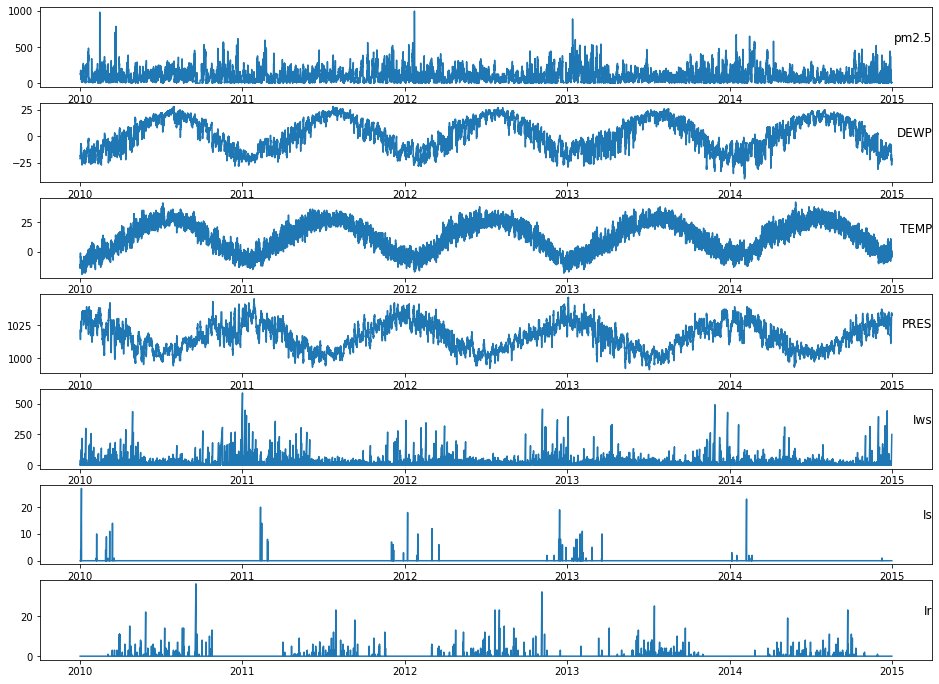

In [10]:
# specify columns to plot
groups = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
i = 1
# plot each column
plt.figure(figsize=(16,12))
for group in groups:
    series = air[group]
    plt.subplot(len(groups), 1, i)
    plt.plot(series)
    plt.title(series.name, y=0.5, loc='right')
    i += 1
    
plt.show()

In [11]:
# plt.rc('figure',figsize=(6, 4))

# plt.hist(air['cbwd'])
# plt.show()

## One Hot Encode Categorical Variable

The categorical variables we have here are ```cbwd, year, month, day, hour```. We will be using one hot encoding to represent the categorical variables into binary vectors. 

For example, categories in ```cbwd``` are ```NW, cv, NE, SE``` will be convert into binary vectors as below:

| NE | NW | SE | cv |
|---|---|---|---|
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 |

However to avoid **Dummy variable trap** which is the common problem in regression model, we have to remove any one of the encoded column. Hence the number of dummy variables necessary to represent a single attribute variable is equal to the number of categories in the variable minus one.

| NW | SE | cv |
|---|---|---|
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |

In [12]:
cbwd_onehot = pd.get_dummies(air['cbwd'], prefix='cbwd', drop_first=True)

hour_onehot = pd.get_dummies(air['hour'], prefix='hour', drop_first=True)
month_onehot = pd.get_dummies(air['month'], prefix='month', drop_first=True)
day_onehot = pd.get_dummies(air['day'], prefix='day', drop_first=True)

In [13]:
# air_combined = pd.concat([air, cbwd_onehot, month_onehot, day_onehot, hour_onehot], axis=1)

air_combined = pd.concat([air, cbwd_onehot], axis=1)
air_combined = air_combined.drop(['year','month','day','hour','cbwd'], axis=1)

In [14]:
air_combined.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1,0,0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1,0,0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1,0,0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1,0,0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1,0,0


## Data Preparation 

In this section, we adjust our dataset so it fits to supervised training requirement for 

In order to train the regression model for predicting ```pm2.5``` for next hour. we have to adjust our dataset so the predictor $x$ and interest value $y+1$ are in the same row.

In [24]:
air_combined_lag1 = air_combined.copy()

air_combined_lag1['label'] = air_combined_lag1['pm2.5'].shift(-1)

# remove last value 
air_combined_lag1 = air_combined_lag1[:-1]
air_combined_lag1.tail()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,label
2014-12-31 18:00:00,10.0,-22,-2.0,1033.0,226.16,0,0,1,0,0,8.0
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,1,0,0,10.0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,1,0,0,10.0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,1,0,0,8.0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,1,0,0,12.0


In [25]:
# seperate dataset into train and test
test_index = air_combined_lag1.index>='2014-12-01'

air_train = air_combined_lag1.loc[~test_index]
air_test = air_combined_lag1.loc[test_index]

# split into input and outputs
train_X, train_y = air_train.values[:, :-1], air_train.values[:, -1]
test_X, test_y = air_test.values[:, :-1], air_test.values[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43080, 10) (43080,) (743, 10) (743,)


In [26]:
from sklearn import preprocessing

# data normalization
scaler = preprocessing.StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

## Predictions

In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np

In [30]:
# prepare a list of ml models
def get_linear_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    print('----------------- Defined %d models' % len(models))
    return models


In [31]:
# fit one model for each variable and each forecast
def fit_model(model, train_X, train_y):
    # clone the model configuration
    local_model = clone(model)
    # fit the model
    return local_model.fit(train_X, train_y)

# return prediction
def make_predictions(model, test_X):
    return model.predict(test_X)
    
# evaluate a suite of models
def evaluate_models(models, train_X, train_y, test_X, test_y):
    pdict = dict()
    for name, model in models.items():
        
        # fit models
        fits = fit_model(model, train_X, train_y)
        
        # make predictions
        predictions = make_predictions(fits, test_X)
        
        # evaluate forecast
        mae = mean_absolute_error(predictions, test_y)
        mse = mean_squared_error(predictions, test_y)
        
        # summarize forecast
        print('%s: %.3f MAE, %.3f MSE' % (name, mae, mse))
        
        # keep results
        d = dict()
        d["predictions"] = predictions
        d["mae"] = mae
        d['mse'] = mse
        pdict[name] = d
        
    return pdict
        

In [32]:
# linear models
print("\n Linear Models")
pdict_linear = evaluate_models(get_linear_models(), train_X_scaled, train_y, test_X_scaled, test_y)


 Linear Models
----------------- Defined 3 models
lr: 12.541 MAE, 598.643 MSE
lasso: 12.655 MAE, 598.381 MSE
ridge: 12.541 MAE, 598.641 MSE


In [33]:
def plot_train_test_pred(train, test, pred, title):
    train_y_series = pd.Series(train, index=air_train.index)
    pred_series = pd.Series(pred, index=air_test.index)
    actual_series = pd.Series(test, index=air_test.index)
    
    plt.figure(figsize=(16,5))
    plt.plot(train_y_series[-1000:], label='training')
    plt.plot(pred_series, label='predict')
    plt.plot(actual_series, label='actual')
    plt.title(title)
    plt.legend()
    plt.show()

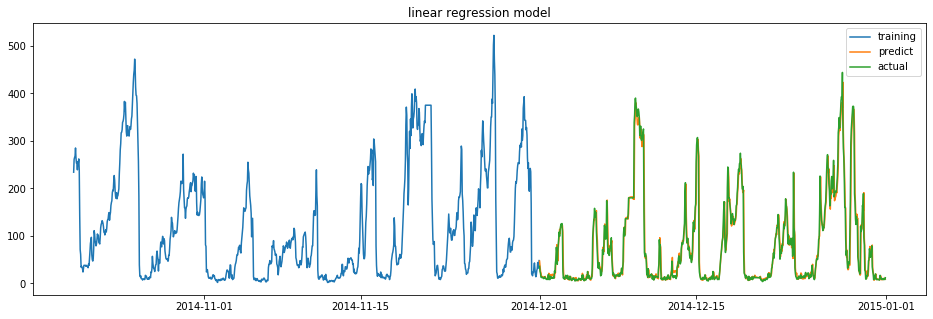

In [34]:
plot_train_test_pred(train_y, test_y, pdict_linear['lr']['predictions'], 'linear regression model')

In [35]:
model = LinearRegression()

model_fit = model.fit(train_X_scaled, train_y)

In [36]:
model_fit.coef_

array([86.67049477,  1.4581835 , -3.64926761, -1.02471539,  0.38130356,
       -0.14834064, -0.55028203, -2.56217064,  1.90247494,  1.69175217])

In [25]:
# plot_train_test_pred(train_y, test_y, pdict_nonlinear['dt']['predictions'], 'knn models')

## Exercise

In [33]:
air_combined.shape

(43824, 10)

In [34]:
air_combined

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,1,0,0
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,1,0,0
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,1,0,0
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,1,0,0
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,1,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,1,0,0


In [214]:
# air_combined_shift = air_combined.shift(-1)
# air_combined_shift.columns = [name+ "(t-1)" for name in air_combined_shift.columns]

# air_combined_shift2 = pd.concat([air_combined, air_combined_shift], axis=1)[:-1]

# air_combined_lag2 = air_combined_shift2.copy()

# air_combined_lag2['label'] = air_combined_lag2['pm2.5'].shift(-50)
# # air_combined_lag2 = air_combined_lag2.drop(['pm2.5'], axis=1)

# # remove last value `
# air_combined_lag2 = air_combined_lag2[:-50]


In [169]:
air_combined_lag2 = air_combined.copy()

air_combined_lag2['label'] = air_combined_lag2['pm2.5'].shift(-3)
air_combined_lag2 = air_combined_lag2.drop(['pm2.5'], axis=1)

# remove last value `
air_combined_lag2 = air_combined_lag2[:-3]
air_combined_lag2[50:].head(10)

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,label
2010-01-03 02:00:00,-8,-7.0,1026.0,65.71,6,0,0,1,0,83.0
2010-01-03 03:00:00,-8,-7.0,1025.0,68.84,7,0,0,1,0,91.0
2010-01-03 04:00:00,-8,-7.0,1024.0,72.86,8,0,0,1,0,86.0
2010-01-03 05:00:00,-9,-8.0,1024.0,76.88,9,0,0,1,0,82.0
2010-01-03 06:00:00,-10,-8.0,1024.0,80.90,10,0,0,1,0,86.0
2010-01-03 07:00:00,-10,-9.0,1024.0,84.92,11,0,0,1,0,78.0
2010-01-03 08:00:00,-10,-9.0,1024.0,89.84,12,0,0,1,0,98.0
2010-01-03 09:00:00,-11,-9.0,1023.0,93.86,13,0,0,1,0,107.0
2010-01-03 10:00:00,-11,-9.0,1023.0,97.88,15,0,0,1,0,90.0
2010-01-03 11:00:00,-11,-9.0,1022.0,102.80,16,0,0,1,0,96.0


In [170]:
# seperate dataset into train and test
test_index = air_combined_lag2.index>='2014-12-01'

air_train = air_combined_lag2.loc[~test_index]
air_test = air_combined_lag2.loc[test_index]

# split into input and outputs
train_X, train_y = air_train.values[:, :-1], air_train.values[:, -1]
test_X, test_y = air_test.values[:, :-1], air_test.values[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43080, 9) (43080,) (741, 9) (741,)


In [171]:
air_train

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,label
2010-01-01 00:00:00,-21,-11.0,1021.0,1.79,0,0,1,0,0,129.0
2010-01-01 01:00:00,-21,-12.0,1020.0,4.92,0,0,1,0,0,129.0
2010-01-01 02:00:00,-21,-11.0,1019.0,6.71,0,0,1,0,0,129.0
2010-01-01 03:00:00,-21,-14.0,1019.0,9.84,0,0,1,0,0,129.0
2010-01-01 04:00:00,-20,-12.0,1018.0,12.97,0,0,1,0,0,129.0
...,...,...,...,...,...,...,...,...,...,...
2014-11-30 19:00:00,-29,1.0,1026.0,129.21,0,0,1,0,0,32.0
2014-11-30 20:00:00,-31,0.0,1028.0,142.17,0,0,1,0,0,33.0
2014-11-30 21:00:00,-28,-2.0,1029.0,152.00,0,0,1,0,0,48.0
2014-11-30 22:00:00,-28,-3.0,1030.0,164.07,0,0,1,0,0,36.0


In [172]:
air_test

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,label
2014-12-01 00:00:00,-25,-4.0,1030.0,190.45,0,0,1,0,0,21.0
2014-12-01 01:00:00,-24,-4.0,1029.0,200.28,0,0,1,0,0,13.0
2014-12-01 02:00:00,-22,-4.0,1030.0,207.43,0,0,1,0,0,13.0
2014-12-01 03:00:00,-22,-5.0,1029.0,215.48,0,0,1,0,0,12.0
2014-12-01 04:00:00,-21,-5.0,1030.0,220.40,0,0,1,0,0,13.0
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,-23,0.0,1032.0,214.09,0,0,1,0,0,8.0
2014-12-31 17:00:00,-22,-1.0,1033.0,221.24,0,0,1,0,0,10.0
2014-12-31 18:00:00,-22,-2.0,1033.0,226.16,0,0,1,0,0,10.0
2014-12-31 19:00:00,-23,-2.0,1034.0,231.97,0,0,1,0,0,8.0


In [173]:
# from sklearn import preprocessing

# data normalization
scaler = preprocessing.StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [174]:
# # linear models
# print("\n Linear Models")
# pdict_linear = evaluate_models(get_linear_models(), train_X_scaled, train_y, test_X_scaled, test_y)

# model = LinearRegression()
model = DecisionTreeRegressor()

model_fit = model.fit(train_X_scaled, train_y)

In [175]:
# model_fit.coef_, model_fit.intercept_

In [176]:
pred = model_fit.predict(test_X_scaled)

In [177]:
list(pred)[45:]

[97.0,
 285.0,
 46.0,
 44.0,
 80.0,
 80.0,
 74.0,
 21.0,
 20.0,
 8.0,
 24.0,
 32.0,
 32.0,
 32.0,
 11.0,
 12.0,
 21.0,
 12.0,
 20.0,
 20.0,
 20.0,
 7.0,
 25.0,
 25.0,
 11.0,
 11.0,
 12.0,
 7.0,
 5.0,
 21.0,
 21.0,
 21.0,
 21.0,
 186.0,
 18.0,
 17.0,
 61.0,
 6.0,
 11.0,
 96.0,
 21.0,
 21.0,
 68.0,
 23.0,
 9.0,
 7.0,
 11.0,
 16.0,
 28.0,
 61.0,
 32.0,
 7.0,
 18.0,
 22.0,
 157.0,
 31.0,
 107.0,
 34.0,
 31.0,
 118.0,
 24.0,
 6.0,
 55.0,
 15.0,
 90.0,
 8.0,
 80.0,
 51.0,
 80.0,
 27.0,
 144.0,
 13.0,
 173.0,
 167.0,
 51.0,
 39.0,
 73.0,
 212.0,
 33.0,
 39.0,
 130.0,
 107.0,
 126.0,
 21.0,
 153.0,
 25.0,
 25.0,
 26.0,
 31.0,
 144.0,
 100.0,
 77.0,
 221.0,
 89.0,
 103.0,
 167.0,
 111.0,
 72.0,
 28.0,
 13.0,
 162.0,
 153.0,
 250.0,
 133.0,
 146.0,
 88.0,
 329.0,
 314.0,
 63.0,
 480.0,
 16.0,
 71.0,
 44.0,
 27.0,
 27.0,
 8.0,
 12.0,
 12.0,
 10.0,
 10.0,
 13.0,
 10.0,
 9.0,
 14.0,
 15.0,
 140.0,
 71.0,
 18.0,
 89.0,
 89.0,
 50.0,
 147.0,
 512.0,
 33.0,
 102.0,
 151.0,
 122.0,
 122.0,
 79.0,
 12.0

In [178]:
list(test_y)[45:]

[123.0,
 126.0,
 111.0,
 26.0,
 11.0,
 13.0,
 9.0,
 9.0,
 13.0,
 17.0,
 16.0,
 11.0,
 11.0,
 17.0,
 9.0,
 9.0,
 11.0,
 8.0,
 15.0,
 14.0,
 9.0,
 7.0,
 6.0,
 8.0,
 11.0,
 9.0,
 11.0,
 9.0,
 8.0,
 5.0,
 6.0,
 9.0,
 6.0,
 7.0,
 7.0,
 6.0,
 9.0,
 11.0,
 10.0,
 10.0,
 8.0,
 7.0,
 10.0,
 8.0,
 17.0,
 9.0,
 18.0,
 10.0,
 6.0,
 6.0,
 9.0,
 8.0,
 7.0,
 8.0,
 14.0,
 12.0,
 25.0,
 11.0,
 16.0,
 17.0,
 13.0,
 9.0,
 9.0,
 9.0,
 11.0,
 11.0,
 32.0,
 97.0,
 115.0,
 130.0,
 138.0,
 158.0,
 140.0,
 150.0,
 149.0,
 109.0,
 84.0,
 60.0,
 38.0,
 32.0,
 44.0,
 31.0,
 31.0,
 30.0,
 16.0,
 17.0,
 19.0,
 33.0,
 71.0,
 66.0,
 61.0,
 83.0,
 122.0,
 119.0,
 95.0,
 93.0,
 102.0,
 174.0,
 137.0,
 80.0,
 63.0,
 72.0,
 59.0,
 59.0,
 72.0,
 79.0,
 77.0,
 96.0,
 54.0,
 34.0,
 18.0,
 22.0,
 21.0,
 15.0,
 13.0,
 11.0,
 17.0,
 18.0,
 16.0,
 17.0,
 18.0,
 16.0,
 15.0,
 17.0,
 19.0,
 15.0,
 22.0,
 20.0,
 21.0,
 32.0,
 20.0,
 31.0,
 40.0,
 102.0,
 117.0,
 100.0,
 100.0,
 136.0,
 136.0,
 136.0,
 136.0,
 136.0,
 136.0,
 145.0

In [179]:
model_fit.coef_

AttributeError: 'DecisionTreeRegressor' object has no attribute 'coef_'

In [180]:
model_fit.kneighbors_graph()

AttributeError: 'DecisionTreeRegressor' object has no attribute 'kneighbors_graph'

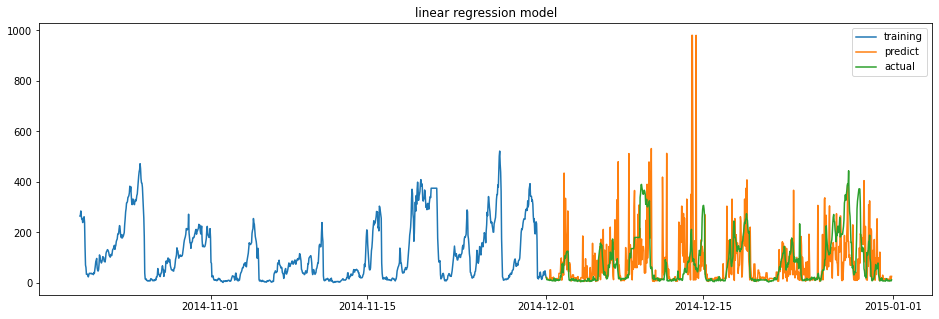

In [181]:
plot_train_test_pred(train_y, test_y, pred, 'linear regression model')

In [118]:
mean_absolute_error(pred, test_y)

69.60353917446383

In [119]:
mean_squared_error(pred, test_y)

7723.630616342493

In [209]:
pred

array([ 61.80253227,  46.25272758,  55.30839164,  37.96171195,
        34.90702445,  42.92753227,  32.63456352,  37.91386039,
        27.45585258,  24.19804008,  35.71757133,  23.3718682 ,
        24.67167289,  19.8562432 ,  17.5437432 ,   5.1038018 ,
        19.35673148,  15.88212211,  23.62040336,  18.43925102,
        29.91923148,  23.50834281,  42.48152585,  47.82596977,
        34.60233695,  73.90116508,  77.07987602,  75.03397758,
        63.41483695,  63.26542289,  58.30350883,  54.14042289,
        51.88944633,  60.09452445,  78.18827445,  89.54081352,
        97.39042289,  79.03983695,  78.1843682 ,  81.67020805,
        83.35868461,  91.18290336,  97.63602836,  87.32987602,
       111.50614555, 101.50443656,  86.28621335,  82.56522758,
        94.89823539,  90.7312432 ,  70.66386039,  56.70389945,
        53.57108695,  56.11893852,  44.12870414,  44.55448539,
        44.59647758,  48.9890557 ,  50.11014945,  40.41288383,
        39.68534477,  38.8249932 ,  26.1609307 ,  32.54

In [210]:
test_y

array([ 15.,  11.,  13.,  11.,  13.,  11.,  12.,  13.,  11.,  26.,  23.,
        43.,  52.,  76.,  66.,  40.,  67.,  81.,  96., 108.,  99., 111.,
       120., 125., 123., 126., 111.,  26.,  11.,  13.,   9.,   9.,  13.,
        17.,  16.,  11.,  11.,  17.,   9.,   9.,  11.,   8.,  15.,  14.,
         9.,   7.,   6.,   8.,  11.,   9.,  11.,   9.,   8.,   5.,   6.,
         9.,   6.,   7.,   7.,   6.,   9.,  11.,  10.,  10.,   8.,   7.,
        10.,   8.,  17.,   9.,  18.,  10.,   6.,   6.,   9.,   8.,   7.,
         8.,  14.,  12.,  25.,  11.,  16.,  17.,  13.,   9.,   9.,   9.,
        11.,  11.,  32.,  97., 115., 130., 138., 158., 140., 150., 149.,
       109.,  84.,  60.,  38.,  32.,  44.,  31.,  31.,  30.,  16.,  17.,
        19.,  33.,  71.,  66.,  61.,  83., 122., 119.,  95.,  93., 102.,
       174., 137.,  80.,  63.,  72.,  59.,  59.,  72.,  79.,  77.,  96.,
        54.,  34.,  18.,  22.,  21.,  15.,  13.,  11.,  17.,  18.,  16.,
        17.,  18.,  16.,  15.,  17.,  19.,  15.,  2